In [40]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd

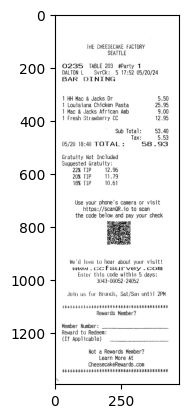

In [ ]:
img = cv2.imread("Downloads/expensify/receipts/cheesecakefactory_20240528_003_page-0001.jpg')
# img = cv2.resize(img, None, fx=2, fy=1, interpolation=cv2.INTER_CUBIC)
plt.imshow(img)

In [42]:
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'


In [43]:
# import re
# def gettot(txt):
#     txt = pytesseract.image_to_string(img)
#     # match = re.search(r'^Total\s*[$:]?\s*(\d+\.\d{2})', txt, re.IGNORECASE | re.MULTILINE)
#     total_lines = re.findall(r'^.*total.*\d+\.\d{2}.*$', txt, re.IGNORECASE | re.MULTILINE)
#     total = next((line for line in total_lines if re.search(r'\BTOTAL\B', line, re.IGNORECASE)), None)

#     # total = match.group(1)
#     print("Total:", total)
    
#     # # Date (MM/DD/YY or MM/DD/YYYY)
#     # date_match = re.search(r'\b(\d{2}/\d{2}/\d{2,4})\b', txt)
#     # date = date_match.group(1) if date_match else None
    
#     # print("Date:", date)
#     # print("Total:", total)
#     print(txt)

In [ ]:

img5 = cv2.imread('Downloads/expensify/receipts/inout_20211211_001_page-0001.jpg')
import easyocr
reader = easyocr.Reader(['en'])
results = reader.readtext(img5)
texts = [item[1] for item in results]
text = " ".join(texts)
mastercard_pattern = re.compile(r'(?i)\bmaster[\s\-]?card\b.*?\$?((?:\d{1,3}(?:,\d{3})+|\d+)\.\d{2})')
is_card = bool(mastercard_pattern.search(text))

In [45]:
print(text)
print(is_card)

YOUR GUEST  NUMBER IS 43 In-N-out  BURGER Linq 320 6 2166 6301 Cashier: SERJIO SA Check 43 TRANS #: 6301 Db]-Db] 5,25 Onion Fry 2.35 Med Soft Drink 2.15 COUNTER-Eat  In 9.75 TAX 8.375% 82 Amount  Due .57 Tender MasterCard 810.57 Change $.00 CHARGE   DETAIL SALE Card Type Mastercard Account ******+++*++5562 R Auth Code NDTQU8 Trans #: 6301 Auth Ref 2015517078 AuTH AMT 810.57 AID: A0000000041010 TVR: 0000008001 TSI 0000 App Name Debit MasterCard ARQC AdCF520879387B06 THANK YOU ! Quest ions / Commients Ca] ] 800-786- |'410 2021-11-30 L1 T6 9;21 PM S10 ,
True


In [60]:
import re

def get_text(image_path):
    results = reader.readtext(image_path)
    lines = [item[1] for item in results]
    return " ".join(lines)

def get_largest_float(text):
    # Improved regex to match numbers with or without commas
    floats = re.findall(r'(?:\d{1,3}(?:,\d{3})+|\d+)\.\d{2}', text)
    # Remove commas before converting to float
    floats = [float(f.replace(',', '')) for f in floats]
    return max(floats) if floats else None

def extract_merchant(text):
    lines = [line.strip() for line in text.split('\n') if line.strip()]
    top_lines = lines[:5]  # consider only top few lines

    skip_keywords = ['receipt', 'invoice', 'order', 'date', 'time', 'tax', 'total', 
                     'number', 'no.', 'guest', 'table', 'party', 'check', 'visit','server','dine in','takeout','purchase']

    for line in top_lines:
        line_lower = line.lower()
        
        if (
            len(line) > 2 and
            not any(k in line_lower for k in skip_keywords) and get_date(line)==None):
            #and
            # not any(char.isdigit() for char in line)):
            return line

    return "Merchant Not Found"

def get_date(lines):
    date_pattern = re.compile(
    r'(\d{1,2}/\d{1,2}/\d{2,4}'                  # 05/20/24
    r'|\d{4}-\d{2}-\d{2}'                        # 2025-06-14
    r'|\d{1,2}-\d{1,2}-\d{2,4}'                  # 05-20-24
    r'|\b\d{1,2}\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Sept|Oct|Nov|Dec|January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{2,4}\b'  # 22 May 2004
    r')',
    re.IGNORECASE)
    date_found = None
    for line in reversed(lines):
        if date_match := date_pattern.search(line):
            date_found = date_match.group(1)
            break
    return date_found

def extract_totals_and_dates(text):
    # Regex patterns
    total_pattern = re.compile(r'(?i)^(?!.*sub\s*total).*?\W*total\W*\s*[:\-]?\s*\$?((?:\d{1,3}(?:,\d{3})+|\d+)\.\d{2})',re.MULTILINE)

    

    mastercard_pattern = re.compile(r'(?i)\bmaster[\s\-]?card\b.*?\$?((?:\d{1,3}(?:,\d{3})+|\d+)\.\d{2})')
    amount_pattern = re.compile(r'(?i)\bpamount\b.*?\$?((?:\d{1,3}(?:,\d{3})+|\d+)\.\d{2})')


    results = []
    lines = text.split('\n')
    is_card = bool(mastercard_pattern.search(text))
    date_found = get_date(lines)

    
    for i, line in enumerate(lines):
        if re.search(r'(?i)sub\s*total', line):
            continue
            
        total_match = total_pattern.search(line)
        if total_match:
            results.append({
                'total': total_match.group(1),
                'date': date_found,
                'payment': 'Card' if is_card==True else 'Cash'
            })
            return results
            
    for i, line in enumerate(lines):
        mastercard_match = mastercard_pattern.search(line)
        if mastercard_match:
            results.append({
                'total': mastercard_match.group(1).replace(',', ''),
                'date': date_found,
                'payment': 'Card' if is_card==True else 'Cash'
            })
            return results
    for i, line in enumerate(lines):
        amount_match = amount_pattern.search(line)
        if amount_match:
            results.append({
                'total': amount_match.group(1).replace(',', ''),
                'date': date_found,
                'payment': 'Card' if is_card==True else 'Cash'
            })
            return results
    largest = get_largest_float(text)
    if largest is not None:
        results.append({
            'total': f"{largest:.2f}",
            'date': date_found,
            'payment': 'Card' if is_card==True else 'Cash'
        })


    return results



# results = extract_totals_and_dates(txt)
# for i, item in enumerate(results, 1):
#     print(f"Receipt {i}:")
#     print(f"  Total: ${item['total']}")
#     print(f"  Date: {item['date']}")
#     print(f" Payment: {item['payment']}")
#     print(f" Merchant: {extract_merchant(txt)}")
    


In [61]:
from dateutil import parser

def normalize_date(date_str):
    try:
        dt = parser.parse(date_str, dayfirst=False, yearfirst=False)
        return dt.strftime('%d/%m/%Y')
    except Exception:
        return None


In [62]:
import glob

folder_path = "C:/Users/iamda/Downloads/expensify/receipts"
all_files = glob.glob(f"{folder_path}/*") 
print(len(all_files))


39


In [63]:
res = []
for i in range(len(all_files)):
    arr = []
    img = cv2.imread(all_files[i])
    txt = pytesseract.image_to_string(img)
    results = extract_totals_and_dates(txt)
    for j, item in enumerate(results, 1):
        arr.append(normalize_date(item['date']))
        arr.append(extract_merchant(txt))
        arr.append(item['payment'])
        arr.append(item['total'])
    res.append(arr)


df = pd.DataFrame(res,columns=['Date','Merchant','Payment','Total'])
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df

C:\Users\iamda\AppData\Local\Temp\ipykernel_22004\980773534.py:16: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


,Date,Merchant,Payment,Total
2,2018-07-21,BART -,Cash,20.00
16,2018-08-24,HaM,Card,47.96
1,2018-12-01,APPLEBEE’S,Cash,115.67
37,2018-12-02,THE VENETIAN” | THE PALAZZO”,Card,1937.66
36,2018-12-02,PID: 0010F336D547,Cash,21.68
21,2019-04-14,MYSTIC,Card,2512.87
31,2019-05-06,SAFEWAY G3.,Cash,100.00
35,2019-05-12,SUPER DUPER,Cash,14.92
22,2019-12-06,OLD NAVY - 03292,Cash,139.60
25,2019-12-31,ee ||,Cash,201.88


In [64]:
# img = cv2.imread(all_files[5])
# plt.imshow(img)
# print(pytesseract.image_to_string(img))

In [65]:
# name = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
# df['Month'] = df['Month'].map(lambda x: calendar.month_name[x])

In [66]:
df['Total']=df['Total'].astype(float)

In [67]:
df=df.dropna()

In [68]:
df

,Date,Merchant,Payment,Total,Year,Month
2,2018-07-21,BART -,Cash,20.00,2018.0,7.0
16,2018-08-24,HaM,Card,47.96,2018.0,8.0
1,2018-12-01,APPLEBEE’S,Cash,115.67,2018.0,12.0
37,2018-12-02,THE VENETIAN” | THE PALAZZO”,Card,1937.66,2018.0,12.0
36,2018-12-02,PID: 0010F336D547,Cash,21.68,2018.0,12.0
21,2019-04-14,MYSTIC,Card,2512.87,2019.0,4.0
31,2019-05-06,SAFEWAY G3.,Cash,100.00,2019.0,5.0
35,2019-05-12,SUPER DUPER,Cash,14.92,2019.0,5.0
22,2019-12-06,OLD NAVY - 03292,Cash,139.60,2019.0,12.0
25,2019-12-31,ee ||,Cash,201.88,2019.0,12.0


In [69]:
df['Month']=df['Month'].astype(int)
df['Year']=df['Year'].astype(int)

C:\Users\iamda\AppData\Local\Temp\ipykernel_22004\1743839015.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month']=df['Month'].astype(int)
C:\Users\iamda\AppData\Local\Temp\ipykernel_22004\1743839015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year']=df['Year'].astype(int)


In [70]:
df

,Date,Merchant,Payment,Total,Year,Month
2,2018-07-21,BART -,Cash,20.00,2018,7
16,2018-08-24,HaM,Card,47.96,2018,8
1,2018-12-01,APPLEBEE’S,Cash,115.67,2018,12
37,2018-12-02,THE VENETIAN” | THE PALAZZO”,Card,1937.66,2018,12
36,2018-12-02,PID: 0010F336D547,Cash,21.68,2018,12
21,2019-04-14,MYSTIC,Card,2512.87,2019,4
31,2019-05-06,SAFEWAY G3.,Cash,100.00,2019,5
35,2019-05-12,SUPER DUPER,Cash,14.92,2019,5
22,2019-12-06,OLD NAVY - 03292,Cash,139.60,2019,12
25,2019-12-31,ee ||,Cash,201.88,2019,12


In [71]:
grouped_df = df.groupby('Month')['Total'].sum()


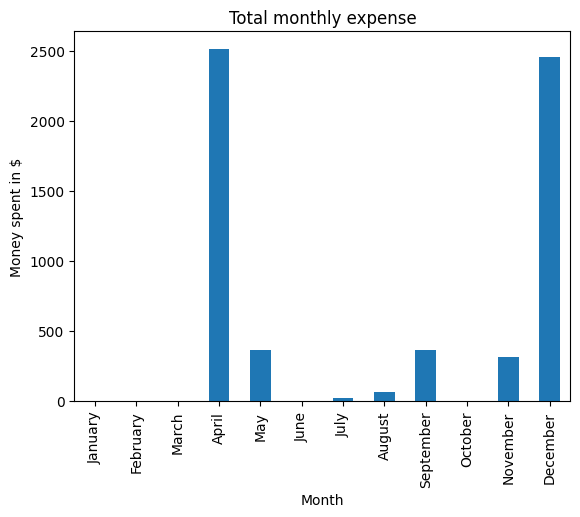

In [72]:
import numpy as np

mon = np.arange(1,13)
month_map = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

grouped_df = grouped_df.reindex(mon, fill_value=0)
grouped_df.index = grouped_df.index.map(month_map)
grouped_df.plot(kind = 'bar')
plt.ylabel("Money spent in $")
plt.title("Total monthly expense")
plt.show()

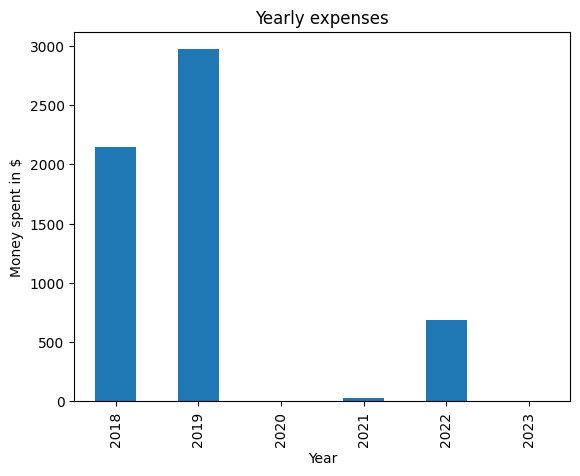

In [73]:
yr = np.arange(df['Year'].min(),df['Year'].max())
grouped_df = df.groupby('Year')['Total'].sum()
grouped_df = grouped_df.reindex(yr, fill_value=0)
grouped_df.plot(kind = 'bar')
plt.title("Yearly expenses")
plt.ylabel("Money spent in $")
plt.show()